In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.optim as optim
import os
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
class DataSet(Dataset):
    def __init__(self, img_path, sigma, transforms=None):
        self.img_path = img_path
        self.transforms = transforms
        self.imgs = os.listdir(img_path)
        self.sigma = sigma

    def __len__(self):
        return len(self.imgs)
    
    def __getitem__(self, idx):
        path_file = os.path.join(self.img_path, self.imgs[idx])
        clean = Image.open(path_file)
        
        transform = transforms.Compose([
            transforms.Resize((256, 256)),  
            transforms.ToTensor()  
        ])

        clean = transform(clean)
        noise = torch.randn(clean.shape) * self.sigma
        noisy = clean + noise
        
        return noisy, clean 

In [ ]:
class FFCNN(nn.Module):
    def __init__(self):
        super(FFCNN, self).__init__()
        

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()  
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x



In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
device

device(type='cuda')

In [ ]:
dataset = DataSet('/home/mint/path', sigma=0.1)


train_loader = DataLoader(dataset, batch_size=2, shuffle=True)

In [8]:
model = FFCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [9]:
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for noisy_images, clean_images in train_loader: 
        noisy_images, clean_images = noisy_images.to(device), clean_images.to(device)
        optimizer.zero_grad()
        outputs = model(noisy_images)  
        outputs = outputs[:, :, :256, :256]  
        loss = criterion(outputs, clean_images)  
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}")

print('Training Finished')

Epoch [1/10], Loss: 0.0023
Epoch [2/10], Loss: 0.0011
Epoch [3/10], Loss: 0.0011
Epoch [4/10], Loss: 0.0010
Epoch [5/10], Loss: 0.0010
Epoch [6/10], Loss: 0.0010
Epoch [7/10], Loss: 0.0009
Epoch [8/10], Loss: 0.0009
Epoch [9/10], Loss: 0.0009
Epoch [10/10], Loss: 0.0008
Training Finished


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3735369..1.3226025].


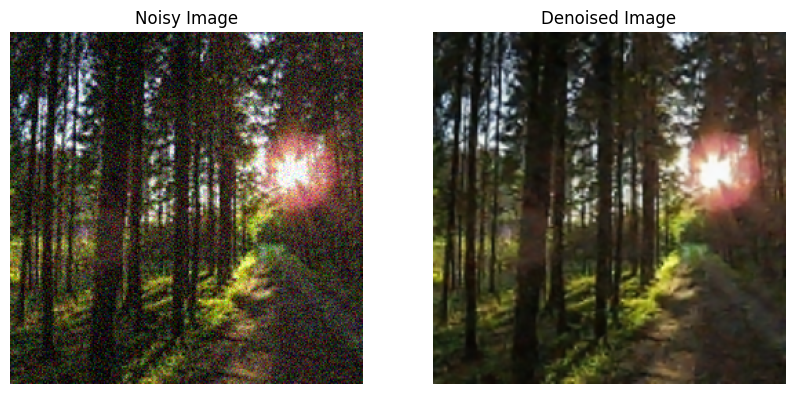

In [23]:
noisy_images, clean_images = next(iter(train_loader))
noisy_image = noisy_images[0].unsqueeze(0).to(device)


with torch.no_grad():
    denoised_image = model(noisy_image)


noisy_image = noisy_image.squeeze().permute(1, 2, 0).cpu().numpy()
denoised_image = denoised_image.squeeze().permute(1, 2, 0).cpu().numpy()


plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(noisy_image)
plt.title('Noisy Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(denoised_image)
plt.title('Denoised Image')
plt.axis('off')

plt.show()

In [ ]:
file_model = '/home/mint/path/model.pth'
torch.save(model.state_dict(), file_model)